<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/Alzheimer_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**讀取資料**

In [1]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/1/uc?id=1aEj8qx7Dkp2TAsiN7nKUtiagDpyc7m7i&export=download&confirm=t'
output = "Alzheimer.zip"
gdown.download(url, output)

file_path = "Alzheimer.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/1/uc?id=1aEj8qx7Dkp2TAsiN7nKUtiagDpyc7m7i&export=download&confirm=t
To: /content/Alzheimer.zip
100%|██████████| 456M/456M [00:02<00:00, 202MB/s]


In [2]:
!pip install lime
!pip install einops

     |████████████████████████████████| 275 kB 4.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=717ce2500dcd35e822e907563688277c2f6a52df819f0f0f348a74ec90bc184d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


**插入套件**

In [3]:
import os
from Load_Dataset import *
from tqdm import tqdm
from util import *
from trainer import trainer
from torchvision.models.resnet import resnet34
from Models import *
import lime
from lime import lime_image
import random
from skimage.segmentation import mark_boundaries

**預設訓練學習率**

In [4]:
lr = 0.001  #學習率
resume = True  #是否使用預訓練資料
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
epoch = 1000
batch_size = 25
momentum = 0.9

**訓練資料**

In [5]:
train_ds, test_ds, idx_to_class = Return_Dataset(batch_size) #設定data loader
model = coatnet_2().to(device) #設定模型

if resume: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=lr,
    betas=(0.9, 0.999),
)
loss_function = nn.CrossEntropyLoss()
trainer = trainer(
    model=model,
    optimizer=optimizer,
    loss_function=loss_function,
    epoch=epoch, 
    resume=resume,
    trainloader=train_ds,
    testloader=test_ds,
    device=device
)
trainer.test_epoch(0) #測試準確度

{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


==> Resuming from checkpoint..

validation......
totle_loss: 1.489682112333517
Accuracy: 0.794371
Saving..


**工具箱初始化**

In [6]:
tool = Utils(model,idx_to_class) 

**獲取影像與標籤**

In [7]:
dataset = ImageFolder('Alzheimer/train')
valset = ImageFolder('Alzheimer/test')

In [8]:
img,lab,pred = tool.get_test_img(dataset) #獲取圖片、標籤、預測結果
tool.is_the_same(lab,pred) #print 預測是否正確

Correct! type: VeryMildDemented


**顯示解釋器對影像的前處理**

  0%|          | 0/10 [00:00<?, ?it/s]

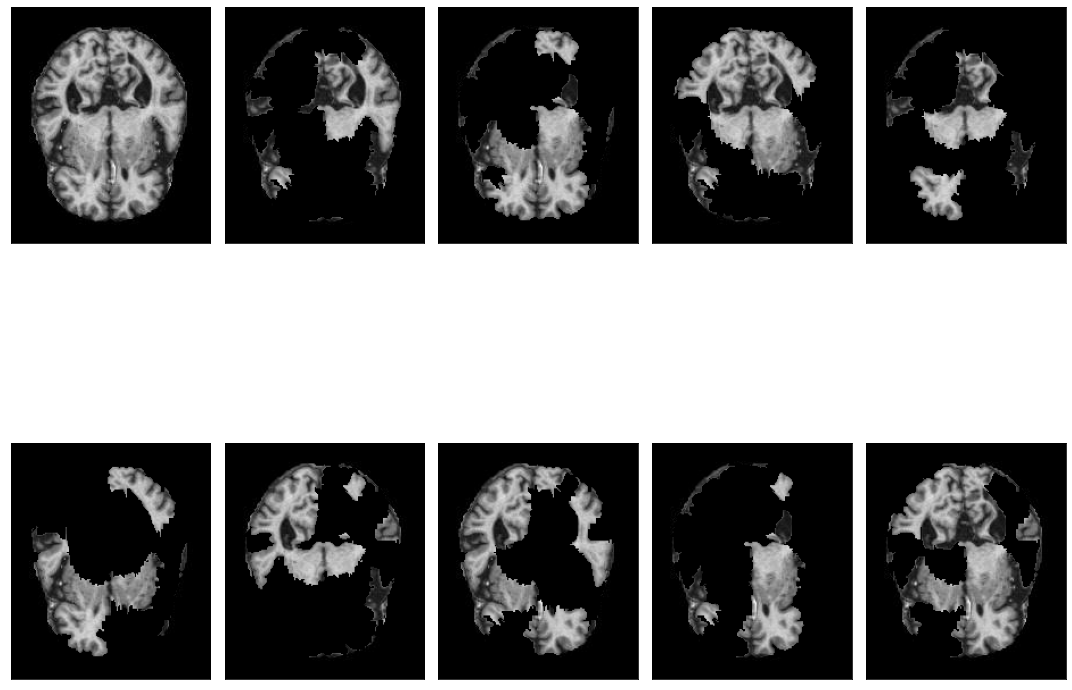

In [9]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(img, tool.show_batch_predict, top_labels=1, hide_color=0,num_samples=10)

**重新獲取影像、標籤與預測結果**

In [10]:
img,lab,pred = tool.get_test_img(dataset)
tool.is_the_same(lab,pred)

Correct! type: VeryMildDemented


**放入解釋器解釋**

In [11]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(img, tool.batch_predict, top_labels=4, hide_color=0,num_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

label: VeryMildDemented predict: VeryMildDemented


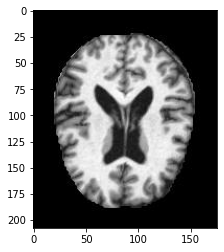

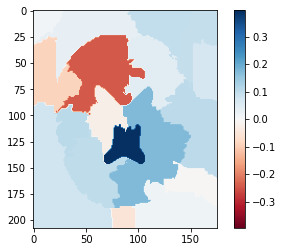

In [12]:
dict_heatmap = dict(exp.local_exp[lab])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
print('label:',idx_to_class[lab],'predict:',idx_to_class[pred])
plt.imshow(img)
plt.show()
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

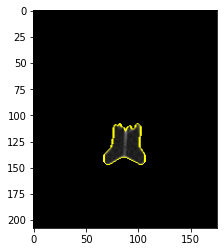

In [13]:
# 只顯示重要部分
temp, mask = exp.get_image_and_mask(lab, positive_only=True, num_features=1, hide_rest=True)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

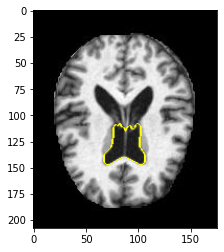

In [14]:
#顯示重要部分
temp, mask = exp.get_image_and_mask(lab, positive_only=True, num_features=1, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

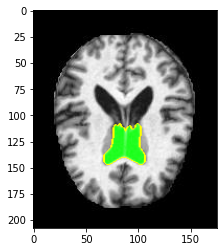

In [15]:
#增加遮罩式意圖
temp, mask = exp.get_image_and_mask(lab, positive_only=False, num_features=1, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

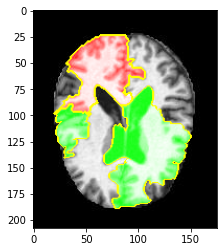

In [16]:
#對於其他類別分類結果
temp, mask = exp.get_image_and_mask(lab, positive_only=False, num_features=4, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

不同類別的解釋結果->每一列為一個類別

search_correct 只尋找正確預測結果

search_error 只尋錯誤預測結果

search_random 隨機尋找正確與錯誤

[0,0,0,0] 尋找標籤為0的類別

[1,2,3,4] 標籤為1234各找一個 **粗體文字**

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

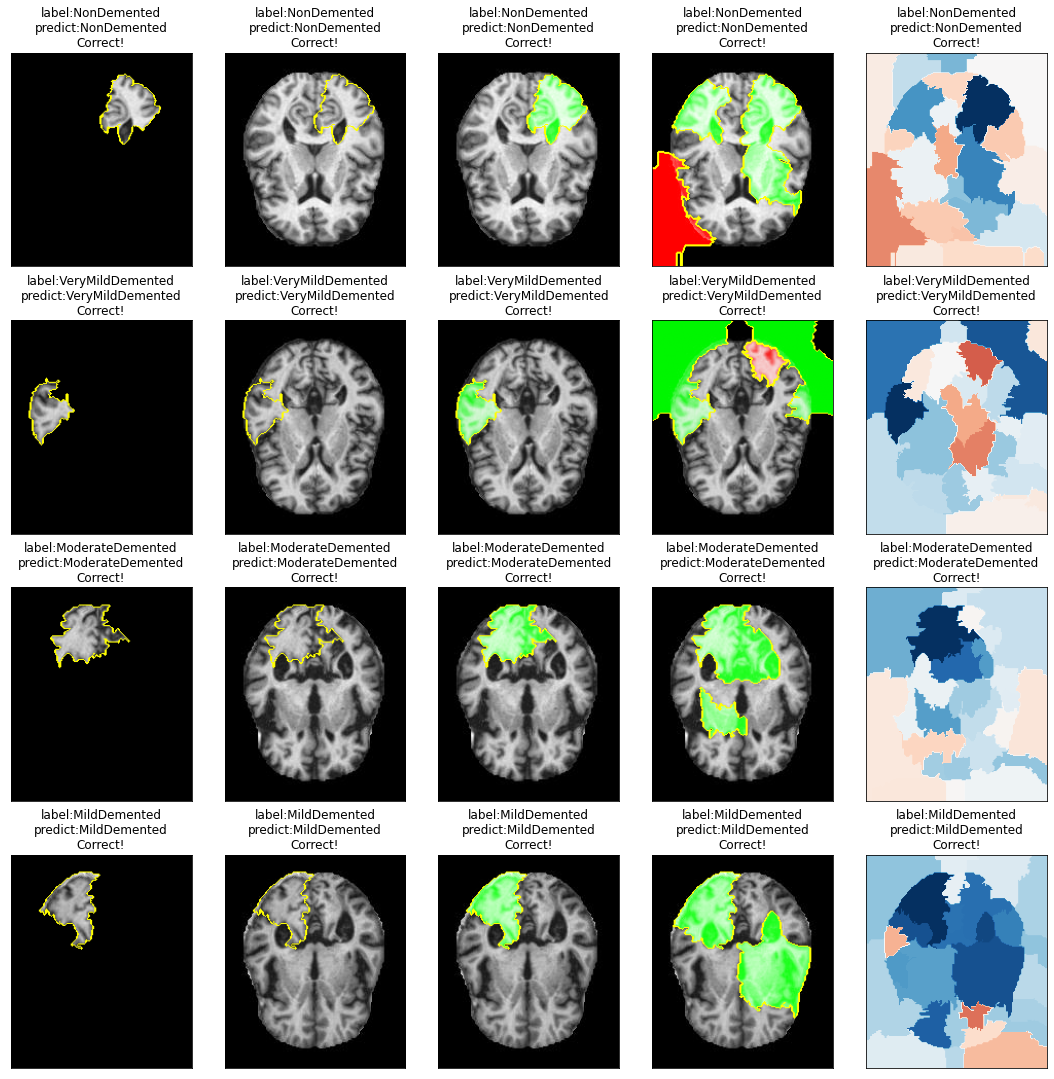

In [17]:
import cv2
img_list = tool.search_correct([0,1,2,3],dataset)
tool.run_all_image_list_and_show(img_list)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

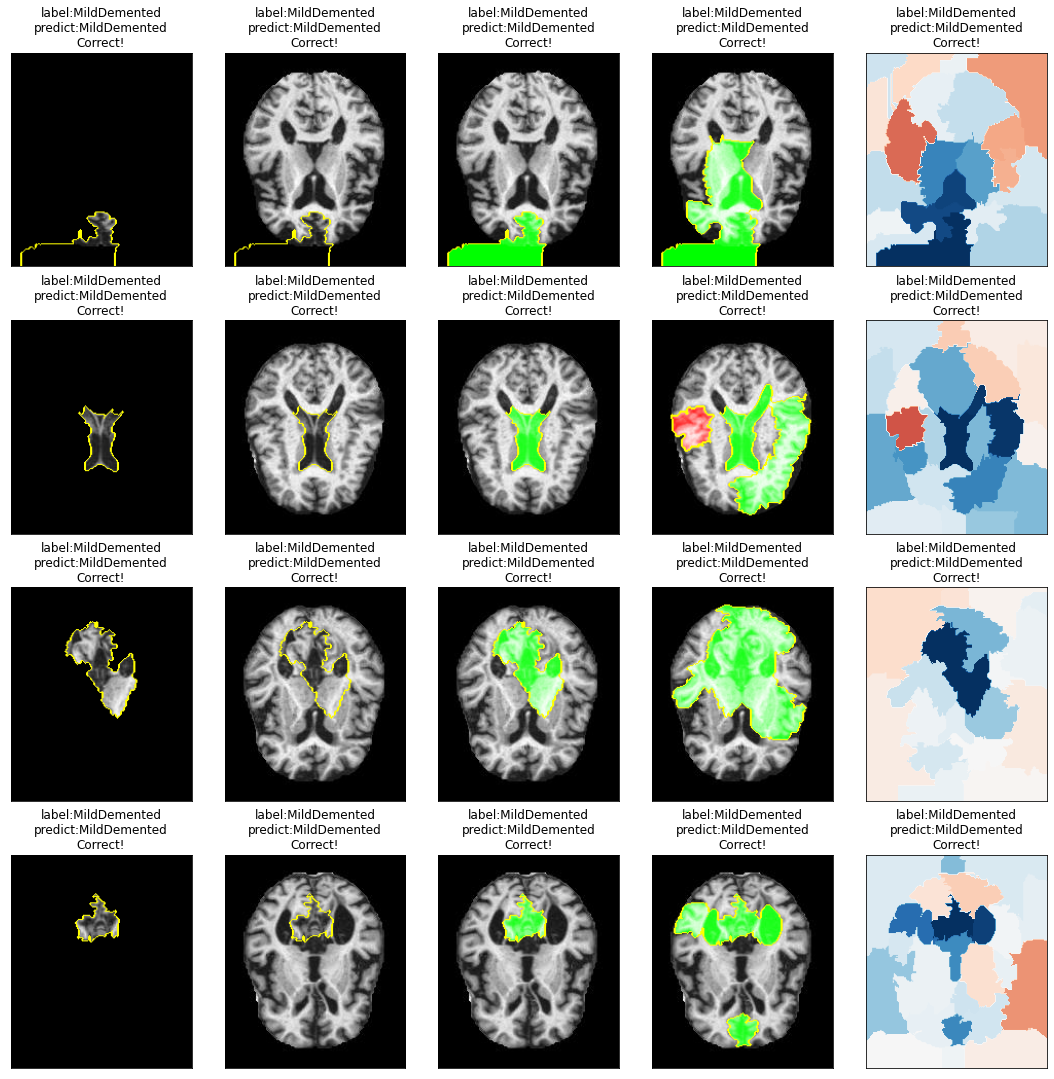

In [18]:
img_list = tool.search_correct([0,0,0,0],dataset)
tool.run_all_image_list_and_show(img_list)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

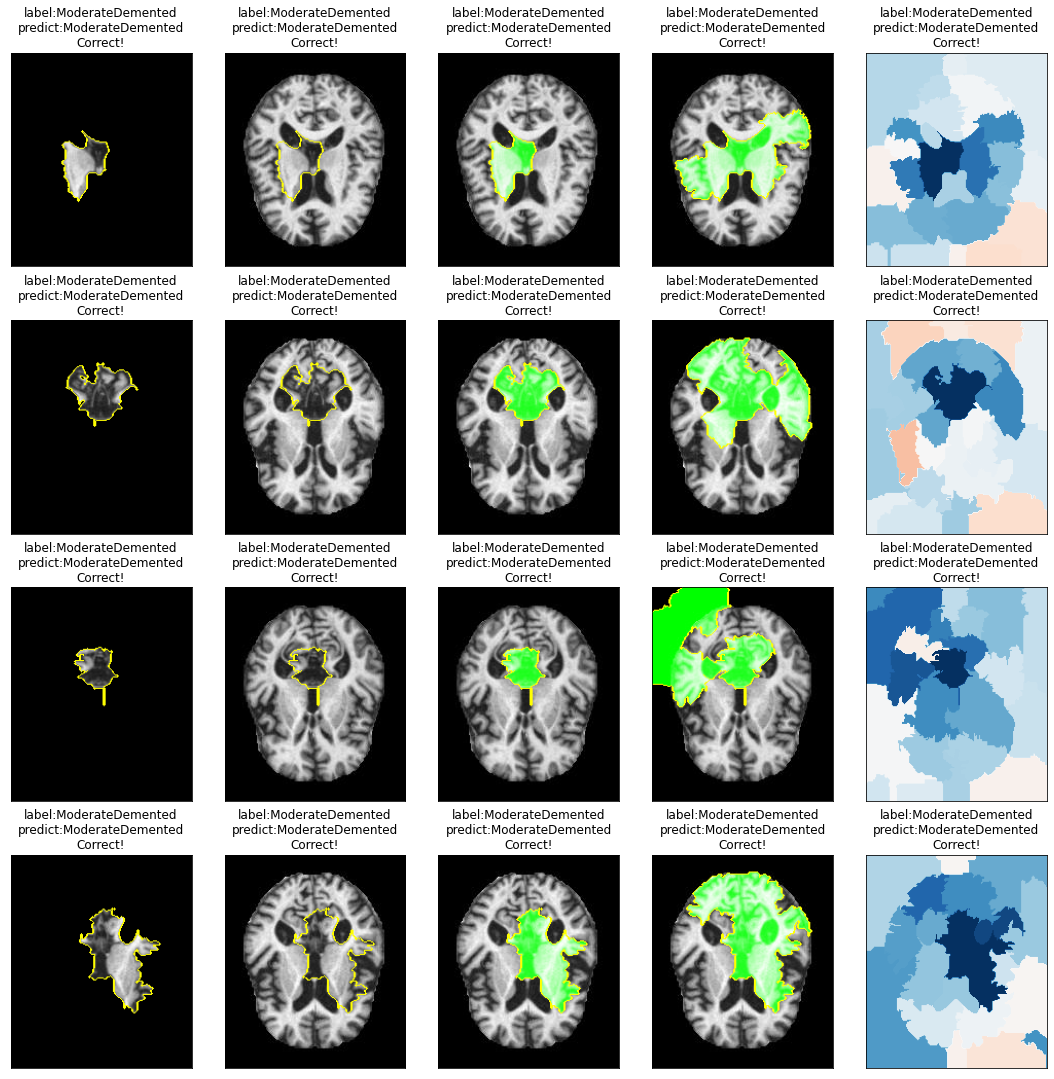

In [19]:
img_list = tool.search_correct([1,1,1,1],dataset)
tool.run_all_image_list_and_show(img_list)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

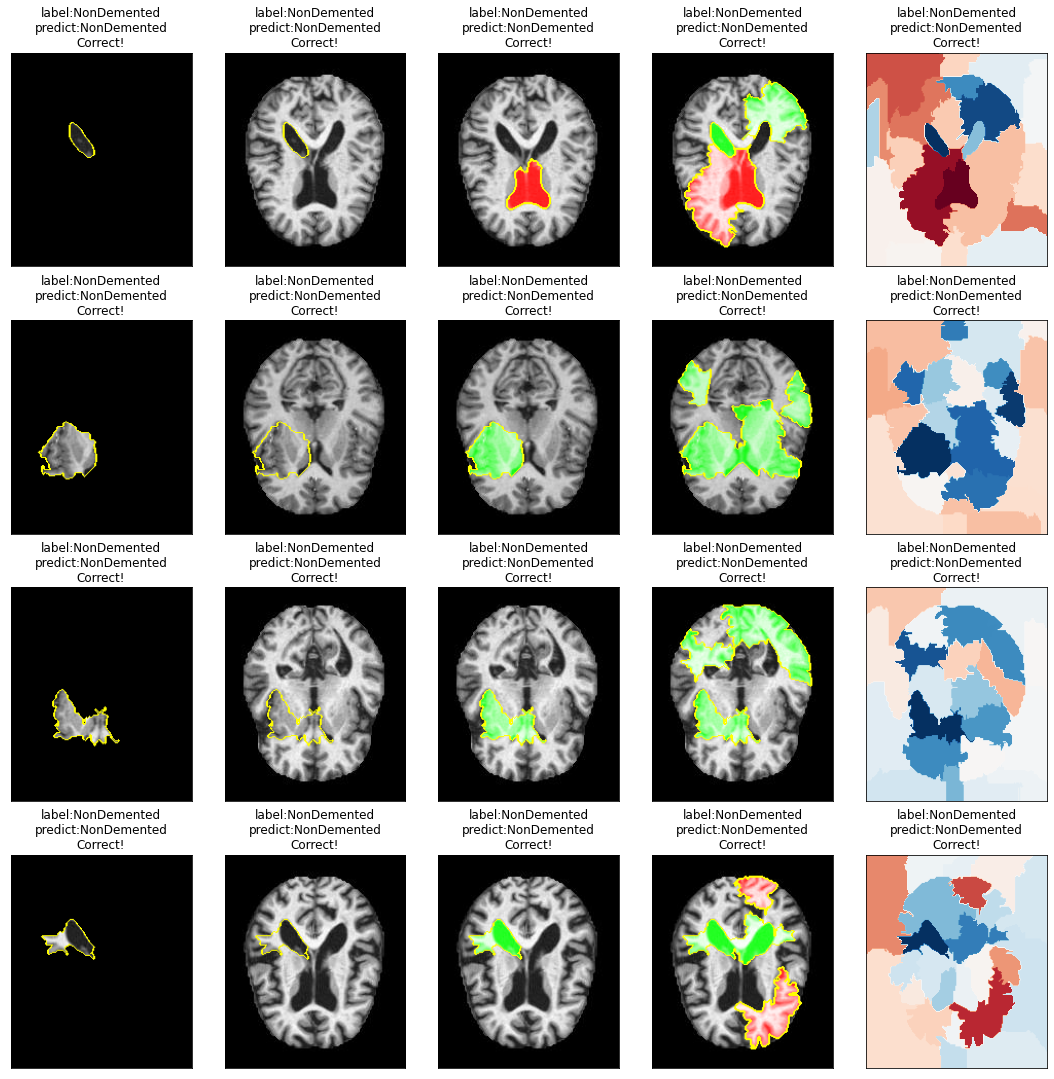

In [20]:
img_list = tool.search_correct([2,2,2,2],dataset)
tool.run_all_image_list_and_show(img_list)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

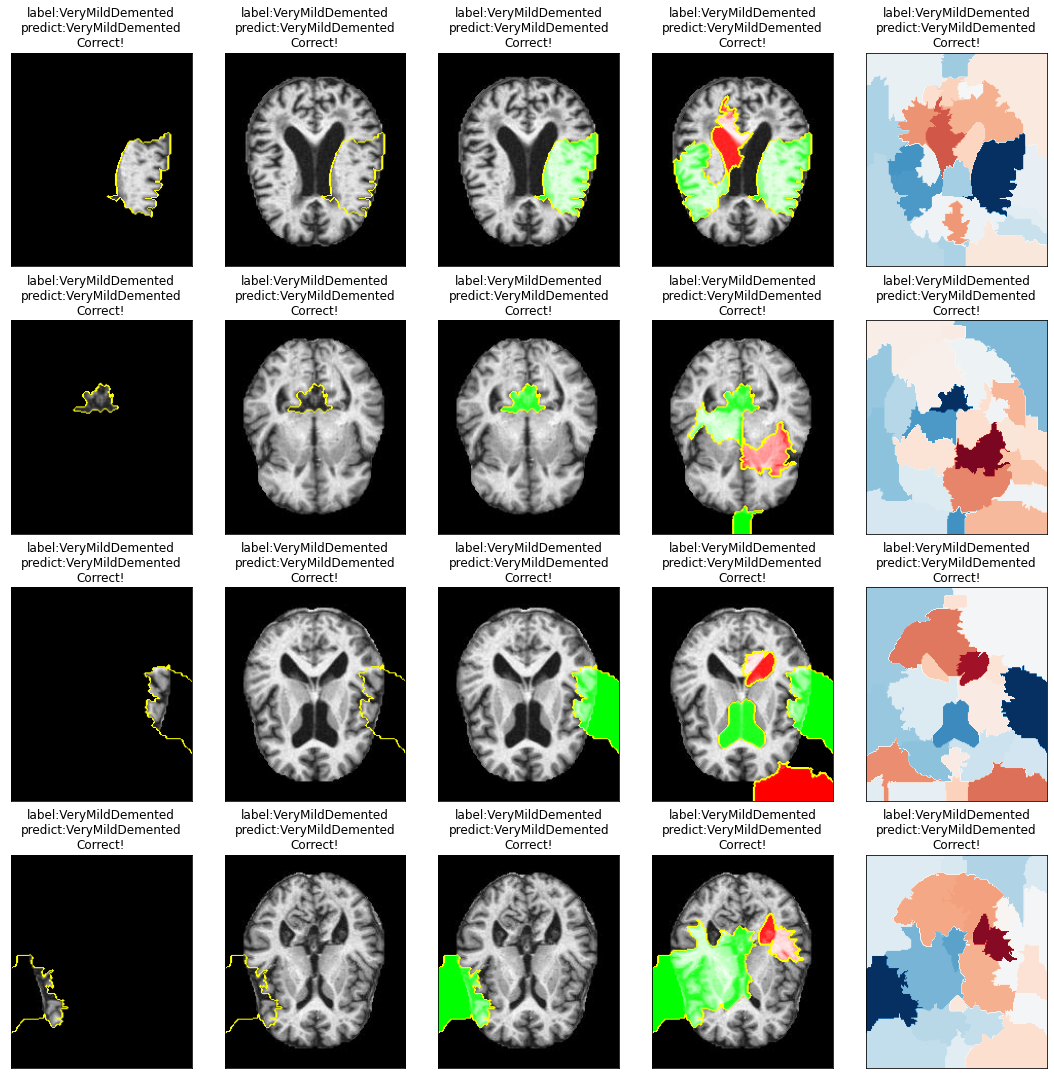

In [21]:
img_list = tool.search_correct([3,3,3,3],dataset)
tool.run_all_image_list_and_show(img_list)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

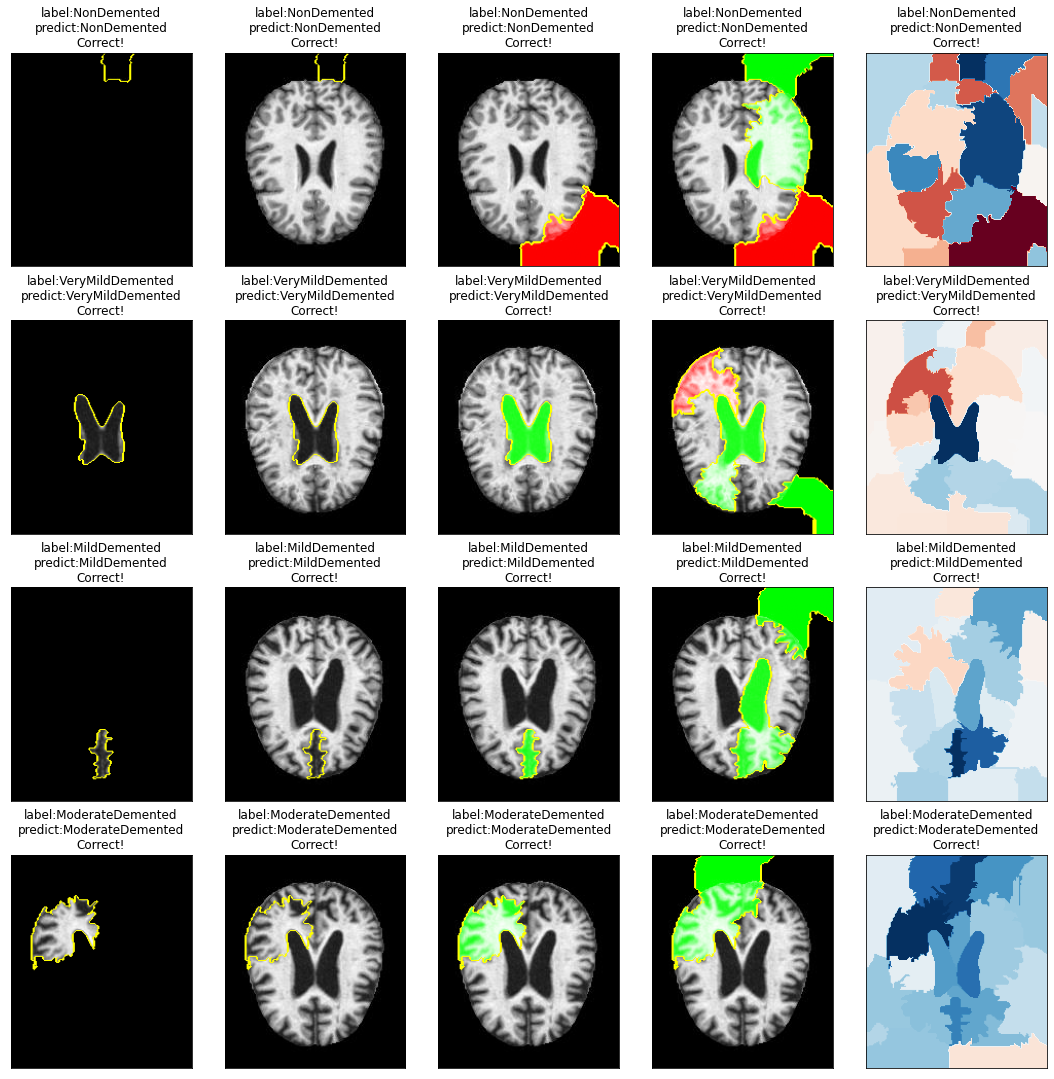

In [23]:
img_list = tool.search_random([0,1,2,3],valset)
tool.run_all_image_list_and_show(img_list)